<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15_MaskRCNN/blob/master/EVA4P1_S15_DepthCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! nvidia-smi

Sat May  9 17:18:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!git clone https://github.com/anilbhatt1/DenseDepth_V1.git

Cloning into 'DenseDepth_V1'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 11.80 MiB | 4.04 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [0]:
!cp -r DenseDepth_V1 '/content/gdrive/My Drive/DepthProject/'

In [15]:
cd gdrive

[Errno 2] No such file or directory: 'gdrive'
/content/gdrive/My Drive/DepthProject


In [13]:
!ls -l

total 10145
-rw------- 1 root root    9471 May  9 17:24 augment.py
-rw------- 1 root root    3946 May  9 17:24 callbacks.py
-rw------- 1 root root    7916 May  9 17:24 data.py
-rw------- 1 root root 2457728 May  9 17:24 demo_depth.npy
-rw------- 1 root root   14392 May  9 17:24 demo.py
-rw------- 1 root root 7372928 May  9 17:24 demo_rgb.npy
-rw------- 1 root root  447290 May  9 17:24 DenseDepth.ipynb
-rw------- 1 root root    1581 May  9 17:24 evaluate.py
drwx------ 2 root root    4096 May  9 17:24 examples
-rw------- 1 root root    2112 May  9 17:24 layers.py
-rw------- 1 root root   35149 May  9 17:24 LICENSE
-rw------- 1 root root     673 May  9 17:24 loss.py
-rw------- 1 root root    3087 May  9 17:24 model.py
drwx------ 2 root root    4096 May  9 17:24 PyTorch
-rw------- 1 root root    3722 May  9 17:24 README.md
drwx------ 2 root root    4096 May  9 17:24 Tensorflow
-rw------- 1 root root    1386 May  9 17:24 test.py
-rw------- 1 root root    4131 May  9 17:24 train.py
-rw------

In [19]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O DenseDepth/nyu.h5

--2020-05-09 17:36:37--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.89.123
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.89.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘DenseDepth/nyu.h5’

DenseDepth/nyu.h5   100%[===================>] 164.89M  9.88MB/s    in 30s     

2020-05-09 17:37:08 (5.50 MB/s) - ‘DenseDepth/nyu.h5’ saved [172897376/172897376]



In [20]:
ls DenseDepth

augment.py      demo.py           examples/  model.py   Tensorflow/
callbacks.py    demo_rgb.npy      layers.py  nyu.h5     test.py
data.py         DenseDepth.ipynb  LICENSE    PyTorch/   train.py
demo_depth.npy  evaluate.py       loss.py    README.md  utils.py


In [21]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from matplotlib import pyplot as plt
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict

MODEL_PATH = 'DenseDepth/nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(MODEL_PATH))

Using TensorFlow backend.


Loading model...

Model loaded (DenseDepth/nyu.h5).


In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [23]:
from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import skimage
from skimage.transform import resize
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
import gc
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from functools import reduce
def make_batch(input_list, batch_size):
  def reducer(cumulator, item):
    if len(cumulator[-1]) < batch_size:
      cumulator[-1].append(item)
      return cumulator
    else:
      cumulator.append([item])
    return cumulator
  return reduce(reducer, input_list, [[]])

In [0]:
fg_bg_zip =  ZipFile('/content/gdrive/My Drive/Test_S15/Test_FG_BG/FG_BG.zip', 'r')

In [0]:
all_files = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]

In [31]:
len(all_files)

88

In [0]:
images = []
for file in all_files[80:83]:
    imgdata = fg_bg_zip.read(file)
    img = Image.open(io.BytesIO(imgdata))
    img = img.resize((640, 480)) 
    x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    images.append(x)

In [0]:
images = np.stack(images, axis=0)

In [34]:
images.shape

(3, 480, 640, 3)

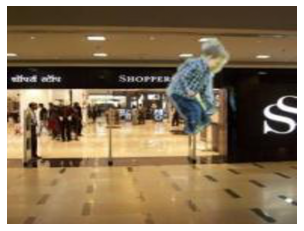

In [35]:
plt.imshow(images[0])
plt.grid('off')
plt.axis('off')
plt.show()

In [0]:
output = predict(model, images)

In [0]:
outputs, inputs = output.copy(), images.copy()

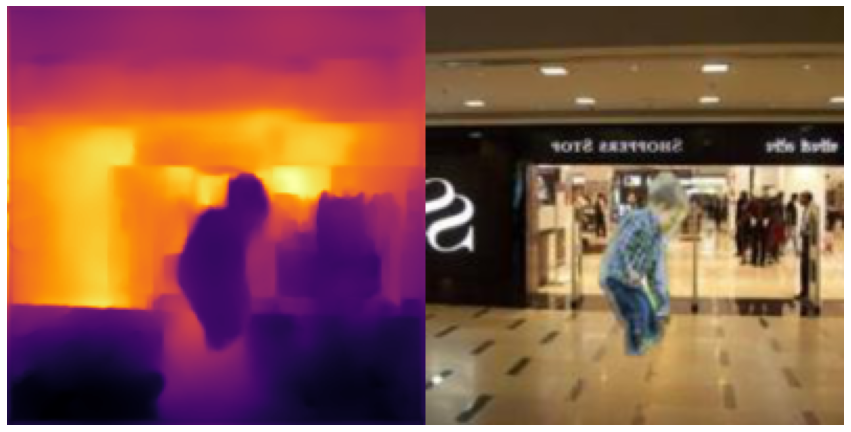

In [38]:
output, input = outputs[2], inputs[2]
output, input = resize(output, (200, 200)), resize(input, (200, 200))
plasma = plt.get_cmap('inferno')
rescaled = output[:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
out_img = plasma(rescaled)[:,:,:3]
img_set = np.hstack([out_img, input])
plt.figure(figsize=(15, 10))
plt.imshow(img_set)
plt.axis('off')
plt.grid('off')

In [0]:
boy = Image.fromarray(rescaled * 255)
boy = boy.convert('L')
byteIO = io.BytesIO()
boy.save(byteIO, format='PNG')
byteArr = byteIO.getvalue()

In [0]:
boy.save('/content/sample_data/boy.jpg')

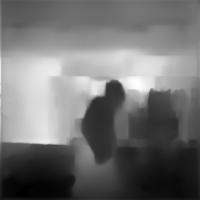

In [41]:
img = Image.open('/content/sample_data/boy.jpg')
img

In [0]:
#!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG/FG_BG.zip"
FG_BG_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG/FG_BG.zip", 'r')

In [0]:
all_files_1 = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]

In [44]:
len(all_files_1)

800008

In [67]:
names_fg_bg       = open('/content/sample_data/fg_bg_names.txt', "w")
names_fg_bg_mask  = open('/content/sample_data/fg_bg_mask_names.txt', "w")
names_all         = open('/content/sample_data/all_names.txt', "w")
for i in range(len(all_files_1)):
  string = str(all_files_1[i]) + '/n'
  names_all.write(string)
  if i <= 400007:
     names_fg_bg_mask.write(string)
  else:
     names_fg_bg.write(string)    
print('Total Files:',i)     
names_fg_bg.close()
names_fg_bg_mask.close()
names_all.close()

Total Files: 800007


In [50]:
all_files_1[0:10]

['nscombe.json',
 'EADME.md',
 'G_BG_Filename_Logs.txt',
 'G_BG_Mask_Filename_Logs.txt',
 'nist_train_small.csv',
 'alifornia_housing_test.csv',
 'nist_test.csv',
 'alifornia_housing_train.csv',
 'G_BG_Mask/Img_fg_bg_mask166570.jpg',
 'G_BG_Mask/Img_fg_bg_mask158550.jpg']

In [0]:
images = []
for file in all_files_1[400008:400011]:
    imgdata = FG_BG_zip.read(file)
    img = Image.open(io.BytesIO(imgdata))
    img = img.resize((640, 480)) 
    x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    images.append(x)

In [0]:
images = np.stack(images, axis=0)

In [57]:
images.shape

(3, 480, 640, 3)

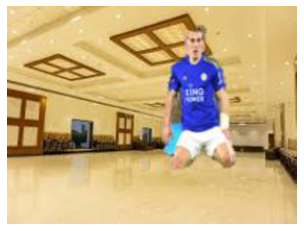

In [58]:
plt.imshow(images[0])
plt.grid('off')
plt.axis('off')
plt.show()

In [0]:
output = predict(model, images)

In [0]:
outputs, inputs = output.copy(), images.copy()

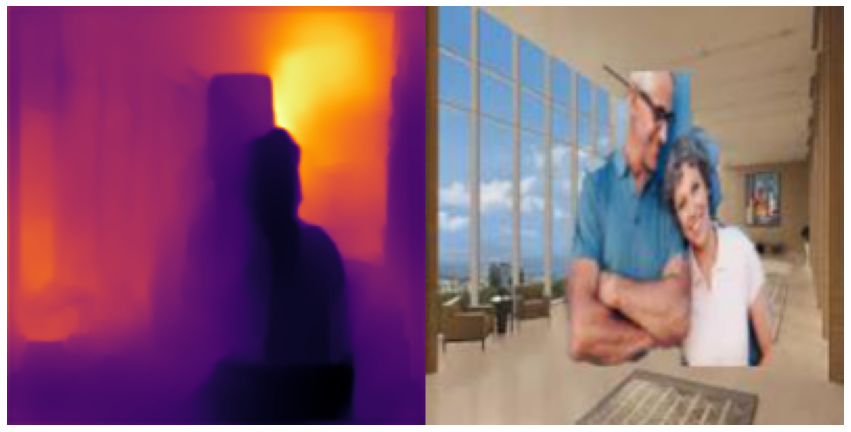

In [61]:
output, input = outputs[2], inputs[2]
output, input = resize(output, (200, 200)), resize(input, (200, 200))
plasma = plt.get_cmap('inferno')
rescaled = output[:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
out_img = plasma(rescaled)[:,:,:3]
img_set = np.hstack([out_img, input])
plt.figure(figsize=(15, 10))
plt.imshow(img_set)
plt.axis('off')
plt.grid('off')

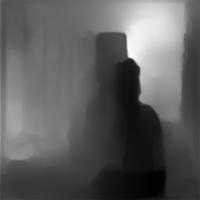

In [65]:
tst = Image.fromarray(rescaled * 255)
tst = tst.convert('L')
byteIO = io.BytesIO()
tst.save(byteIO, format='JPEG')
byteArr = byteIO.getvalue()
tst.save('/content/sample_data/tst_1.jpg')
img = Image.open('/content/sample_data/tst_1.jpg')
img

In [0]:
!cp '/content/sample_data/all_names.txt' '/content/gdrive/My Drive/EVA4P1_S15/'
!cp '/content/sample_data/fg_bg_mask_names.txt' '/content/gdrive/My Drive/EVA4P1_S15/'
!cp '/content/sample_data/fg_bg_names.txt' '/content/gdrive/My Drive/EVA4P1_S15/'